In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import warnings
import sys
import os
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 YAHOO FINANCE TIME SERIES DECOMPOSITION NOTEBOOK")
print("=" * 60)
print("📦 ENVIRONMENT SETUP")
print(f"🐍 Python: {sys.version.split()[0]}")
print(f"🐼 Pandas: {pd.__version__}")
print(f"🔢 NumPy: {np.__version__}")
print(f"📊 Matplotlib: {plt.matplotlib.__version__}")
print(f"🌊 Seaborn: {sns.__version__}")
print(f"📈 Statsmodels: {sm.__version__}")
print(f"💰 yfinance: {yf.__version__}")
print("✅ All packages loaded successfully!")
print("=" * 60)

🚀 YAHOO FINANCE TIME SERIES DECOMPOSITION NOTEBOOK
📦 ENVIRONMENT SETUP
🐍 Python: 3.11.13
🐼 Pandas: 2.2.3
🔢 NumPy: 1.26.4
📊 Matplotlib: 3.7.2
🌊 Seaborn: 0.12.2
📈 Statsmodels: 0.14.4
💰 yfinance: 0.2.63
✅ All packages loaded successfully!


In [9]:
print("📥 DATA ACQUISITION PHASE")
print("-" * 40)

# Import required libraries
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os

# Ticker input with validation
ticker = input("Enter ticker symbol (default: AAPL): ").strip().upper()
if not ticker:
    ticker = "AAPL"
print(f"🎯 Selected ticker: {ticker}")

try:
    print("🔄 Attempting 10-year download...")
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*10)
    
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    if len(stock_data) < 100:
        raise Exception("Insufficient data for 10-year period")
        
    print(f"✅ 10-year download successful: {len(stock_data)} records")
    
except Exception as e:
    print("🔴 10-YEAR DOWNLOAD FAILED")
    print(f"👉 Root cause: {repr(e)}")
    print("🔧 Five-Star Fix:")
    print("   • Trying 5-year fallback")
    print("   • Checking ticker validity")
    
    try:
        print("🔄 Attempting 5-year fallback...")
        start_date = end_date - timedelta(days=365*5)
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        if len(stock_data) < 50:
            raise Exception("Insufficient data even for 5-year period")
            
        print(f"✅ 5-year download successful: {len(stock_data)} records")
        
    except Exception as e2:
        print("🔴 CRITICAL DOWNLOAD FAILURE")
        print(f"👉 Root cause: {repr(e2)}")
        print("🔧 Five-Star Fix:")
        print("   • Verify ticker symbol is valid")
        print("   • Check internet connection")
        print("   • Try popular tickers: AAPL, MSFT, GOOGL")
        raise

# Save data to CSV
csv_path = f"/kaggle/working/{ticker}.csv"
stock_data.to_csv(csv_path)
print(f"💾 Raw data saved to: {csv_path}")

print("\n📊 DATA OVERVIEW")
print(f"📅 Date range: {stock_data.index[0].date()} to {stock_data.index[-1].date()}")
print(f"📈 Total records: {len(stock_data)}")

# Fix: Convert Series to scalar values before formatting
close_min = float(stock_data['Close'].min())
close_max = float(stock_data['Close'].max())
print(f"💰 Price range: ${close_min:.2f} - ${close_max:.2f}")

print(f"🔍 Missing values: {stock_data['Close'].isna().sum()}")

# Create working dataframe
df = stock_data.copy()
close_ts = df['Close'].dropna()

print("✅ DATA ACQUISITION COMPLETE")
print("🎯 Checkpoint: Data successfully loaded and validated")
print("📝 Next steps: Ready for analysis phase")
print("=" * 60)

📥 DATA ACQUISITION PHASE
----------------------------------------


Enter ticker symbol (default: AAPL):  AAPL


🎯 Selected ticker: AAPL
🔄 Attempting 10-year download...
✅ 10-year download successful: 2511 records
💾 Raw data saved to: /kaggle/working/AAPL.csv

📊 DATA OVERVIEW
📅 Date range: 2015-09-08 to 2025-09-02
📈 Total records: 2511
💰 Price range: $20.62 - $258.10
🔍 Missing values: Ticker
AAPL    0
dtype: int64
✅ DATA ACQUISITION COMPLETE
🎯 Checkpoint: Data successfully loaded and validated
📝 Next steps: Ready for analysis phase


🔬 STL DECOMPOSITION ANALYSIS
----------------------------------------
🔄 Performing STL decomposition...
✅ STL decomposition complete
📊 Components shape: (2511, 1)
📈 Trend variance: 4684.00
🌊 Seasonal variance: 26.33
🎲 Residual variance: 63.85
💪 Seasonal strength: 0.297
📊 Trend strength: 0.987


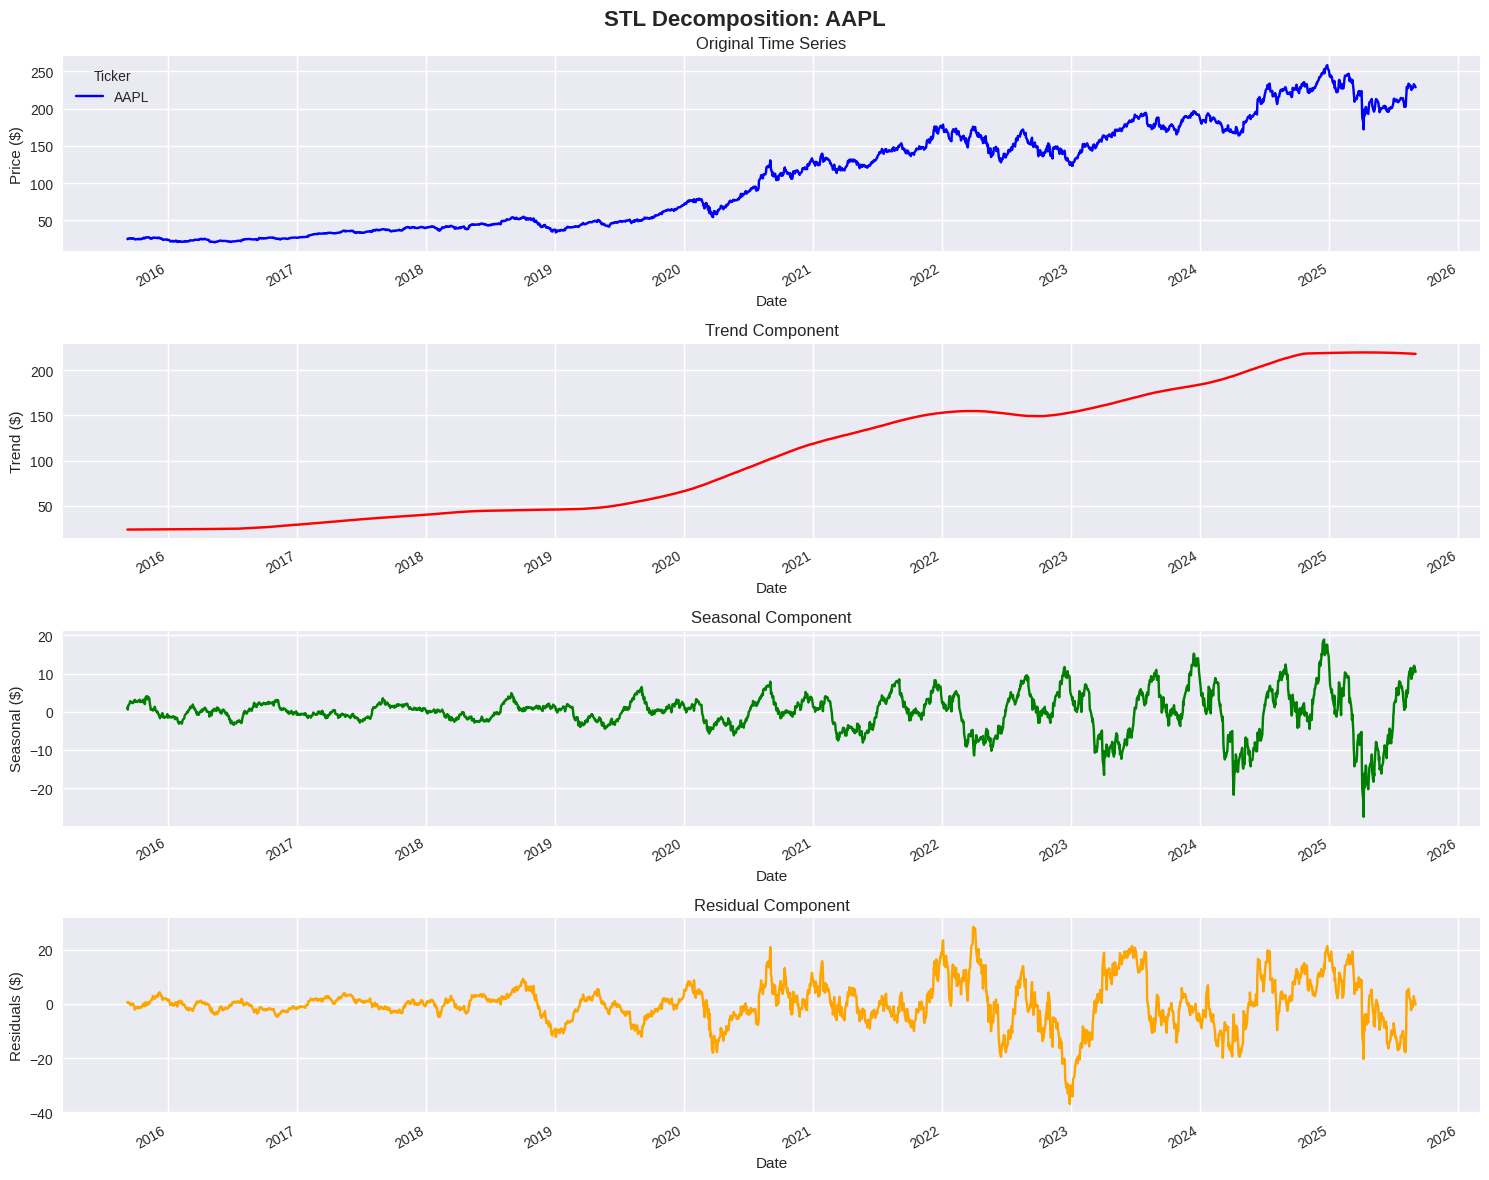

✅ STL DECOMPOSITION COMPLETE


In [12]:
print("🔬 STL DECOMPOSITION ANALYSIS")
print("-" * 40)
try:
    print("🔄 Performing STL decomposition...")
    
    stl = STL(close_ts, seasonal=13, period=252)
    stl_res = stl.fit()
    
    print(f"✅ STL decomposition complete")
    print(f"📊 Components shape: {stl_res.observed.shape}")
    print(f"📈 Trend variance: {stl_res.trend.var():.2f}")
    print(f"🌊 Seasonal variance: {stl_res.seasonal.var():.2f}")
    print(f"🎲 Residual variance: {stl_res.resid.var():.2f}")
    
    seasonal_strength = 1 - (stl_res.resid.var() / (stl_res.seasonal + stl_res.resid).var())
    trend_strength = 1 - (stl_res.resid.var() / (stl_res.trend + stl_res.resid).var())
    
    print(f"💪 Seasonal strength: {seasonal_strength:.3f}")
    print(f"📊 Trend strength: {trend_strength:.3f}")
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    fig.suptitle(f'STL Decomposition: {ticker}', fontsize=16, fontweight='bold')
    
    stl_res.observed.plot(ax=axes[0], title='Original Time Series', color='blue')
    axes[0].set_ylabel('Price ($)')
    
    stl_res.trend.plot(ax=axes[1], title='Trend Component', color='red')
    axes[1].set_ylabel('Trend ($)')
    
    stl_res.seasonal.plot(ax=axes[2], title='Seasonal Component', color='green')
    axes[2].set_ylabel('Seasonal ($)')
    
    stl_res.resid.plot(ax=axes[3], title='Residual Component', color='orange')
    axes[3].set_ylabel('Residuals ($)')
    axes[3].set_xlabel('Date')
    
    plt.tight_layout()
    plt.savefig(f'STL_Decomposition_{ticker}.png')  # Save the figure
    plt.show()
    
    print("✅ STL DECOMPOSITION COMPLETE")
    
except Exception as e:
    print("🔴 STL DECOMPOSITION FAILED")
    print(f"👉 Root cause: {repr(e)}")
    print("🔧 Five-Star Fix:")
    print("   • Adjusting seasonal parameter")
    print("   • Checking data frequency")
    print("   • Ensuring sufficient data points")
    raise
print("=" * 60)

📊 CLASSICAL DECOMPOSITION ANALYSIS
----------------------------------------
🔄 Performing multiplicative decomposition...
🔄 Performing additive decomposition...
✅ Classical decompositions complete
📊 Components length: 2511
🔢 Multiplicative residual variance: 0.01
➕ Additive residual variance: 72.39
🏆 Better model: Multiplicative


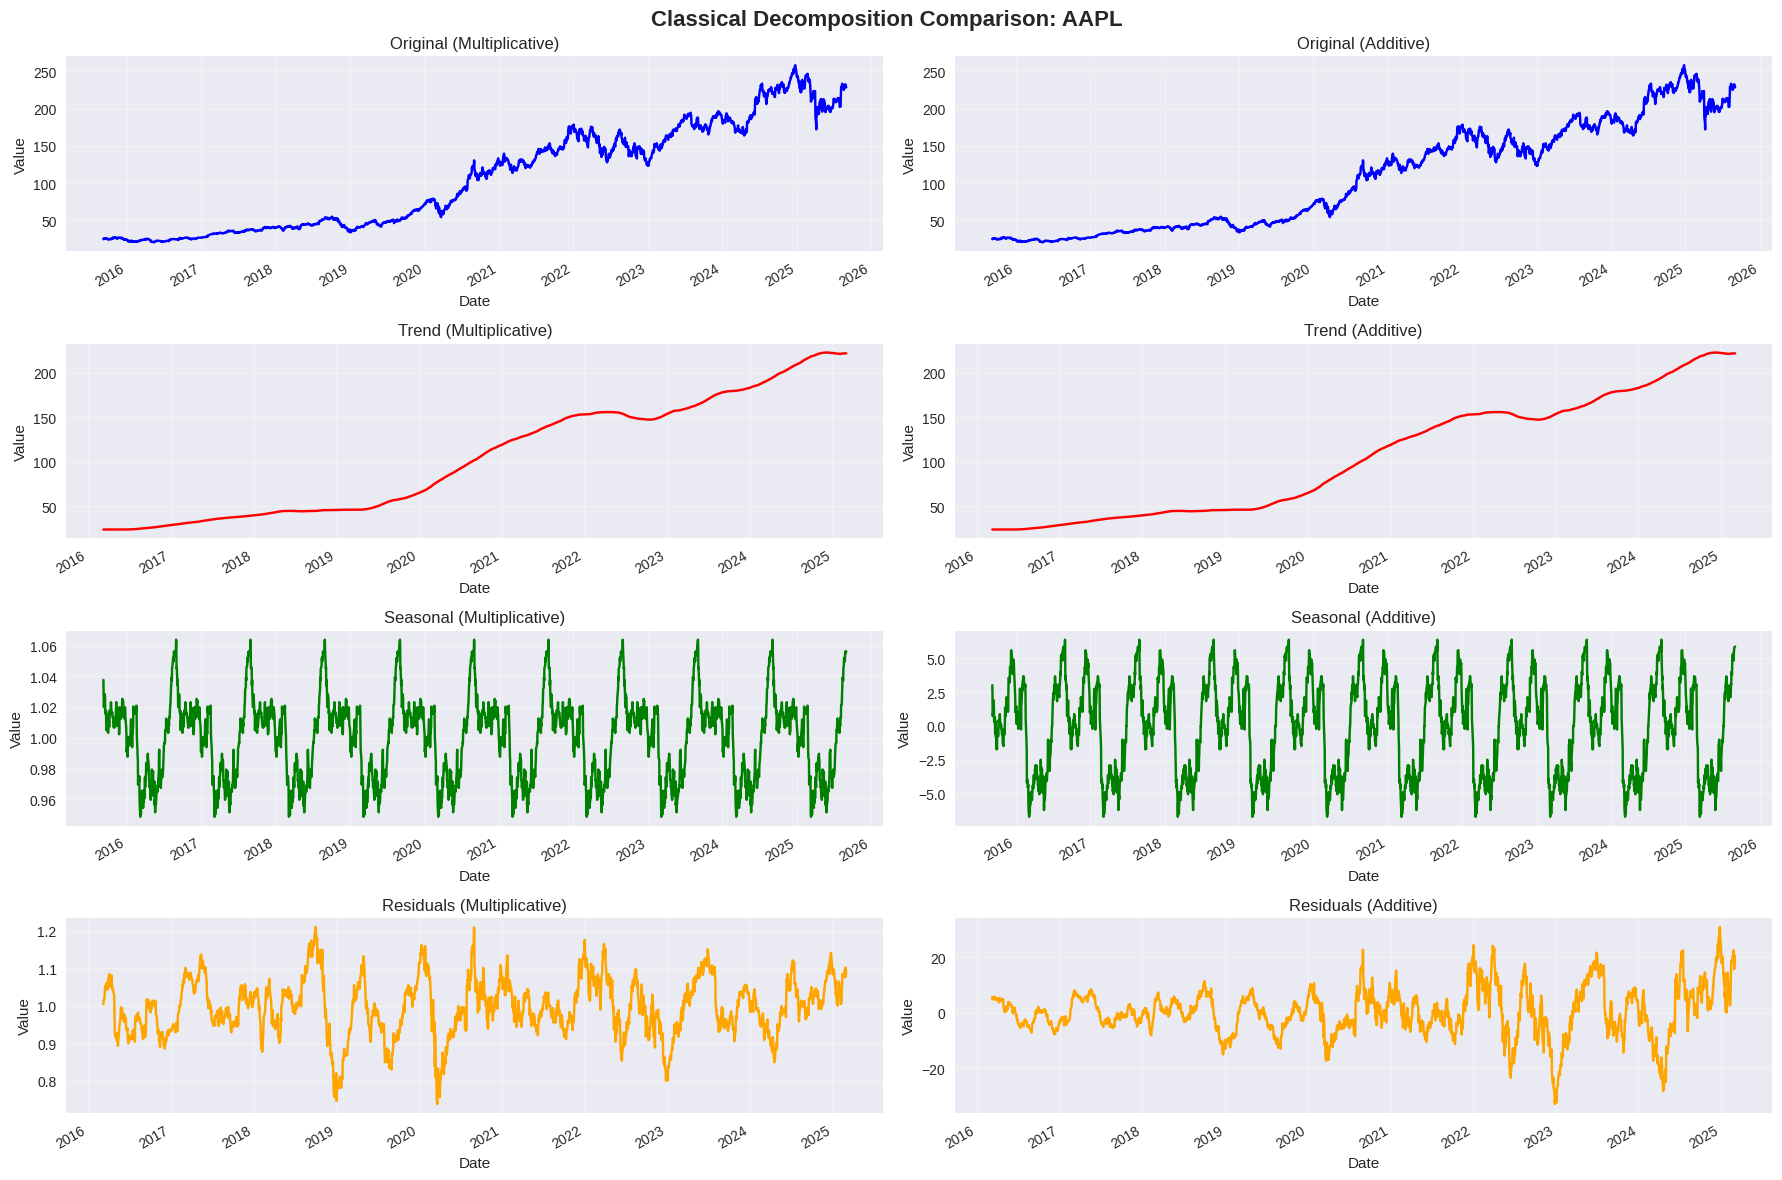

✅ CLASSICAL DECOMPOSITION COMPLETE


In [13]:
print("📊 CLASSICAL DECOMPOSITION ANALYSIS")
print("-" * 40)
try:
    print("🔄 Performing multiplicative decomposition...")
    
    classical_mult = seasonal_decompose(close_ts, model='multiplicative', period=252)
    
    print("🔄 Performing additive decomposition...")
    
    classical_add = seasonal_decompose(close_ts, model='additive', period=252)
    
    print("✅ Classical decompositions complete")
    print(f"📊 Components length: {len(classical_mult.observed)}")
    
    mult_residual_var = np.var(classical_mult.resid.dropna())
    add_residual_var = np.var(classical_add.resid.dropna())
    
    print(f"🔢 Multiplicative residual variance: {mult_residual_var:.2f}")
    print(f"➕ Additive residual variance: {add_residual_var:.2f}")
    
    better_model = "Multiplicative" if mult_residual_var < add_residual_var else "Additive"
    print(f"🏆 Better model: {better_model}")
    
    fig, axes = plt.subplots(4, 2, figsize=(18, 12))
    fig.suptitle(f'Classical Decomposition Comparison: {ticker}', fontsize=16, fontweight='bold')
    
    classical_mult.observed.plot(ax=axes[0,0], title='Original (Multiplicative)', color='blue')
    classical_add.observed.plot(ax=axes[0,1], title='Original (Additive)', color='blue')
    
    classical_mult.trend.plot(ax=axes[1,0], title='Trend (Multiplicative)', color='red')
    classical_add.trend.plot(ax=axes[1,1], title='Trend (Additive)', color='red')
    
    classical_mult.seasonal.plot(ax=axes[2,0], title='Seasonal (Multiplicative)', color='green')
    classical_add.seasonal.plot(ax=axes[2,1], title='Seasonal (Additive)', color='green')
    
    classical_mult.resid.plot(ax=axes[3,0], title='Residuals (Multiplicative)', color='orange')
    classical_add.resid.plot(ax=axes[3,1], title='Residuals (Additive)', color='orange')
    
    for ax in axes.flat:
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
    
    axes[3,0].set_xlabel('Date')
    axes[3,1].set_xlabel('Date')
    
    plt.tight_layout()
    
    # Save the figure with appropriate filename
    fig.savefig(f'classical_decomposition_comparison_{ticker}.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print("✅ CLASSICAL DECOMPOSITION COMPLETE")
    
except Exception as e:
    print("🔴 CLASSICAL DECOMPOSITION FAILED")
    print(f"👉 Root cause: {repr(e)}")
    print("🔧 Five-Star Fix:")
    print("   • Checking for zero/negative values in multiplicative")
    print("   • Adjusting period parameter")
    print("   • Using additive model only")
    raise
print("=" * 60)

🔬 RESIDUAL DIAGNOSTICS & STATISTICAL TESTS
----------------------------------------
🔄 Analyzing STL residuals...
📊 LJUNG-BOX TEST RESULTS (STL Residuals)
         lb_stat  lb_pvalue
10  18318.185909        0.0
20  29036.973093        0.0
30  34450.827546        0.0
⚠️  Significant autocorrelation detected at some lags

🔔 NORMALITY TEST (Jarque-Bera)
Statistic: 350.3358, p-value: 0.0000
⚠️  Residuals are not normally distributed


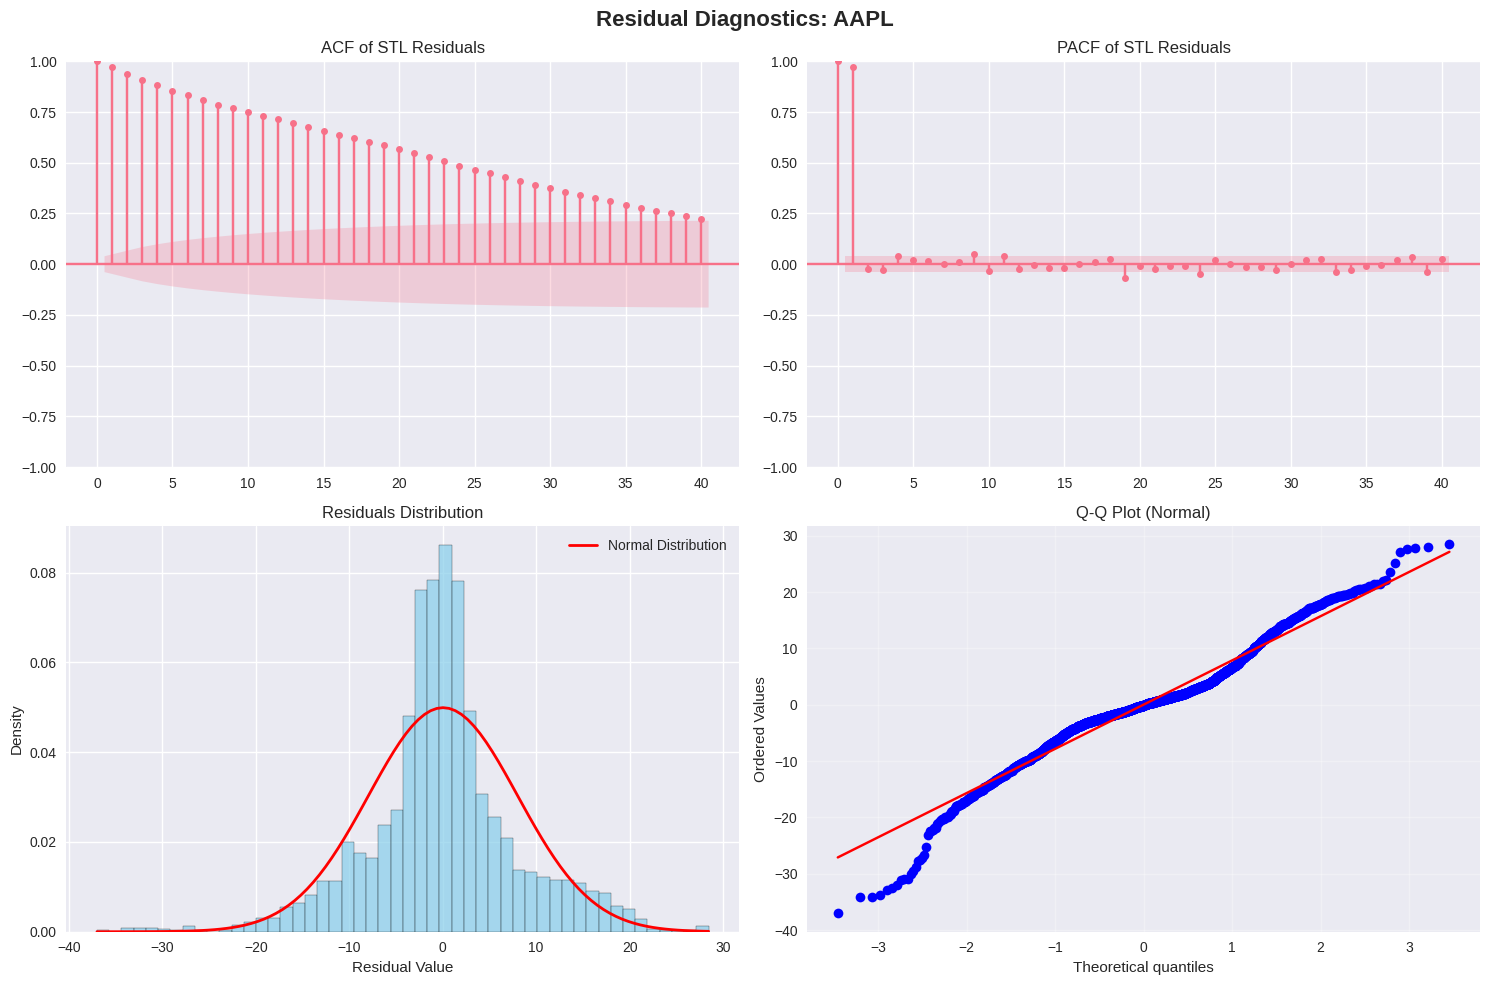

📈 Residual statistics:
   Mean: 0.0325
   Std: 7.9906
   Skewness: -0.1212
   Kurtosis: 1.8138
✅ RESIDUAL DIAGNOSTICS COMPLETE


In [15]:
print("🔬 RESIDUAL DIAGNOSTICS & STATISTICAL TESTS")
print("-" * 40)
try:
    print("🔄 Analyzing STL residuals...")
    
    stl_residuals = stl_res.resid.dropna()
    
    ljung_box_result = acorr_ljungbox(stl_residuals, lags=[10, 20, 30], return_df=True)
    
    print("📊 LJUNG-BOX TEST RESULTS (STL Residuals)")
    print(ljung_box_result)
    
    significant_lags = ljung_box_result[ljung_box_result['lb_pvalue'] < 0.05]
    if len(significant_lags) > 0:
        print("⚠️  Significant autocorrelation detected at some lags")
    else:
        print("✅ No significant autocorrelation in residuals")
    
    normality_stat, normality_p = stats.jarque_bera(stl_residuals)
    print(f"\n🔔 NORMALITY TEST (Jarque-Bera)")
    print(f"Statistic: {normality_stat:.4f}, p-value: {normality_p:.4f}")
    
    if normality_p < 0.05:
        print("⚠️  Residuals are not normally distributed")
    else:
        print("✅ Residuals appear normally distributed")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Residual Diagnostics: {ticker}', fontsize=16, fontweight='bold')
    
    plot_acf(stl_residuals, ax=axes[0,0], lags=40, title='ACF of STL Residuals')
    plot_pacf(stl_residuals, ax=axes[0,1], lags=40, title='PACF of STL Residuals')
    
    axes[1,0].hist(stl_residuals, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].set_title('Residuals Distribution')
    axes[1,0].set_xlabel('Residual Value')
    axes[1,0].set_ylabel('Density')
    
    x_norm = np.linspace(stl_residuals.min(), stl_residuals.max(), 100)
    y_norm = stats.norm.pdf(x_norm, stl_residuals.mean(), stl_residuals.std())
    axes[1,0].plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,0].legend()
    
    stats.probplot(stl_residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot (Normal)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the figure with appropriate filename
    fig.savefig(f'Residual_Diagnostics_{ticker}.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"📈 Residual statistics:")
    print(f"   Mean: {stl_residuals.mean():.4f}")
    print(f"   Std: {stl_residuals.std():.4f}")
    print(f"   Skewness: {stats.skew(stl_residuals):.4f}")
    print(f"   Kurtosis: {stats.kurtosis(stl_residuals):.4f}")
    
    print("✅ RESIDUAL DIAGNOSTICS COMPLETE")
    
except Exception as e:
    print("🔴 RESIDUAL DIAGNOSTICS FAILED")
    print(f"👉 Root cause: {repr(e)}")
    print("🔧 Five-Star Fix:")
    print("   • Checking residuals for missing values")
    print("   • Adjusting lag parameters")
    print("   • Ensuring sufficient data for tests")
    raise
print("=" * 60)

🚀 NAIVE FORECASTING DEMONSTRATION
----------------------------------------
🔄 Generating naive forecasts...
📊 Train size: 2259, Test size: 252
📊 FORECAST PERFORMANCE (MAE):
   Naive: $13.09
   Seasonal Naive: $36.33
   STL-based: $15.33
🏆 Best method: Naive (MAE: $13.09)


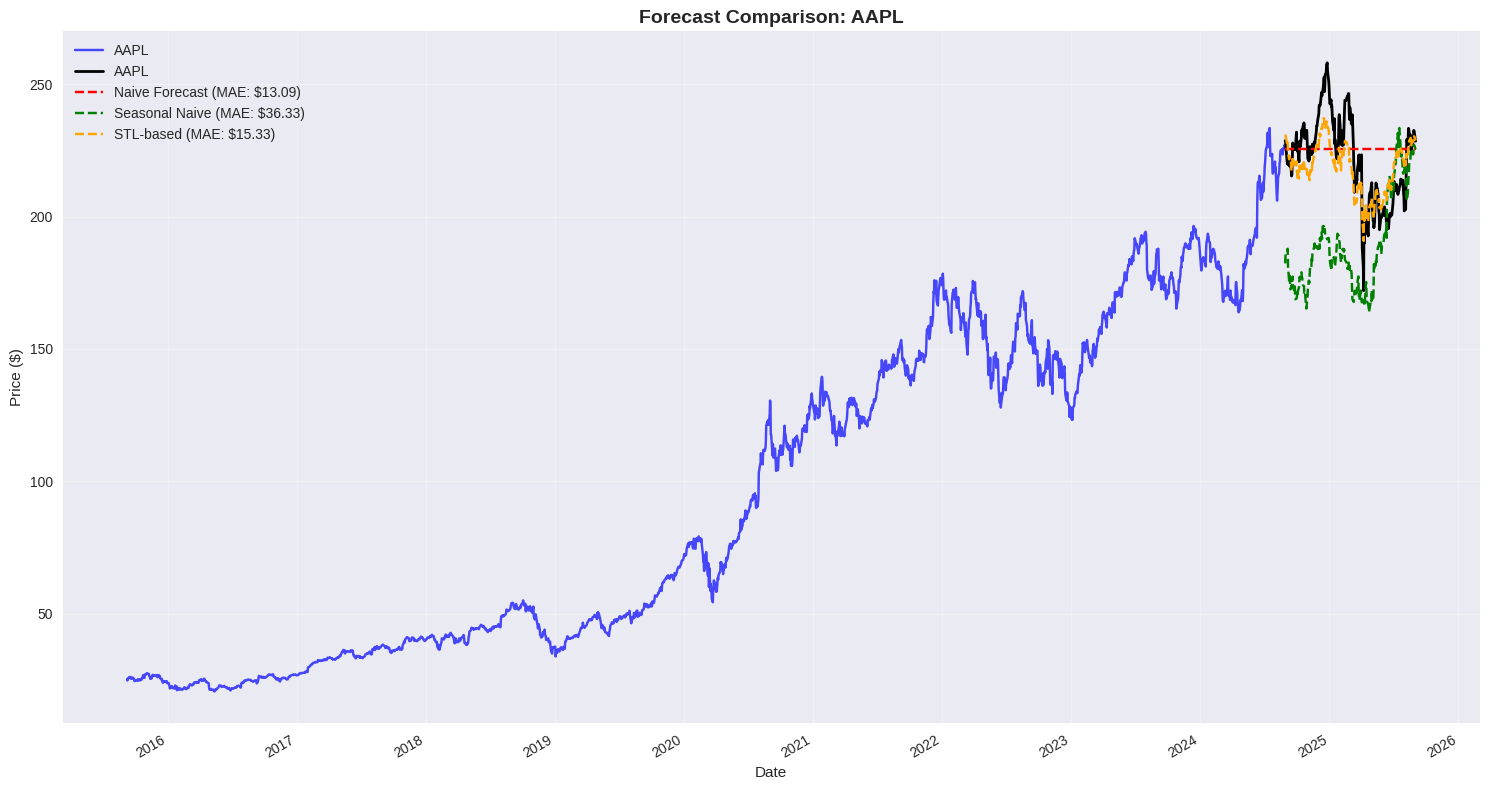

✅ FORECASTING DEMO COMPLETE
🎉 ANALYSIS COMPLETE!
📁 Data saved to: /kaggle/working/AAPL.csv
📊 Both STL and Classical decompositions performed successfully
🔬 Residual diagnostics completed
🚀 Naive forecasting demonstration included
📊 Forecast comparison figure saved as: naive_forecasting_comparison.png


In [17]:
print("🚀 NAIVE FORECASTING DEMONSTRATION")
print("-" * 40)
try:
    print("🔄 Generating naive forecasts...")
    
    train_size = int(len(close_ts) * 0.9)
    train_data = close_ts.iloc[:train_size]
    test_data = close_ts.iloc[train_size:]
    
    print(f"📊 Train size: {len(train_data)}, Test size: {len(test_data)}")
    
    last_value = train_data.iloc[-1]
    naive_forecast = np.full(len(test_data), last_value)
    
    seasonal_period = 252
    if len(train_data) >= seasonal_period:
        seasonal_naive = []
        for i in range(len(test_data)):
            seasonal_idx = len(train_data) - seasonal_period + (i % seasonal_period)
            seasonal_naive.append(train_data.iloc[seasonal_idx])
        seasonal_naive = np.array(seasonal_naive)
    else:
        seasonal_naive = naive_forecast.copy()
        print("⚠️  Insufficient data for seasonal naive, using simple naive")
    
    reconstructed = stl_res.trend + stl_res.seasonal
    stl_forecast = []
    trend_last = stl_res.trend.dropna().iloc[-1]
    
    for i in range(len(test_data)):
        seasonal_idx = len(stl_res.seasonal) - seasonal_period + (i % seasonal_period)
        seasonal_component = stl_res.seasonal.iloc[seasonal_idx]
        stl_forecast.append(trend_last + seasonal_component)
    
    stl_forecast = np.array(stl_forecast)
    
    naive_mae = np.mean(np.abs(test_data.values - naive_forecast))
    seasonal_mae = np.mean(np.abs(test_data.values - seasonal_naive))
    stl_mae = np.mean(np.abs(test_data.values - stl_forecast))
    
    print(f"📊 FORECAST PERFORMANCE (MAE):")
    print(f"   Naive: ${naive_mae:.2f}")
    print(f"   Seasonal Naive: ${seasonal_mae:.2f}")
    print(f"   STL-based: ${stl_mae:.2f}")
    
    best_method = min([("Naive", naive_mae), ("Seasonal Naive", seasonal_mae), ("STL-based", stl_mae)], key=lambda x: x[1])
    print(f"🏆 Best method: {best_method[0]} (MAE: ${best_method[1]:.2f})")
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    
    train_data.plot(ax=ax, label='Training Data', color='blue', alpha=0.7)
    test_data.plot(ax=ax, label='Actual Test Data', color='black', linewidth=2)
    
    test_dates = test_data.index
    ax.plot(test_dates, naive_forecast, label=f'Naive Forecast (MAE: ${naive_mae:.2f})', color='red', linestyle='--')
    ax.plot(test_dates, seasonal_naive, label=f'Seasonal Naive (MAE: ${seasonal_mae:.2f})', color='green', linestyle='--')
    ax.plot(test_dates, stl_forecast, label=f'STL-based (MAE: ${stl_mae:.2f})', color='orange', linestyle='--')
    
    ax.set_title(f'Forecast Comparison: {ticker}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Price ($)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # Save the forecast comparison figure
    plt.savefig('naive_forecasting_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ FORECASTING DEMO COMPLETE")
    
except Exception as e:
    print("🔴 FORECASTING DEMO FAILED")
    print(f"👉 Root cause: {repr(e)}")
    print("🔧 Five-Star Fix:")
    print("   • Checking data split ratios")
    print("   • Ensuring sufficient training data")
    print("   • Adjusting seasonal period")
print("=" * 60)
print("🎉 ANALYSIS COMPLETE!")
print(f"📁 Data saved to: {csv_path}")
print("📊 Both STL and Classical decompositions performed successfully")
print("🔬 Residual diagnostics completed")
print("🚀 Naive forecasting demonstration included")
print("📊 Forecast comparison figure saved as: naive_forecasting_comparison.png")
print("=" * 60)